<a href="https://colab.research.google.com/github/abubakerKhaled/Cars-Classification/blob/main/05_Comparison_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/StanfordCars_Project'
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')

model_names = [
    "vgg19_scratch_top20",
    "vit_tiny_scratch_top20",
    "inceptionv1_finetuned_top20",
    "resnet50_finetuned_top20"
]

results = {}

print("Loading Scorecards...")
for name in model_names:
    path = os.path.join(RESULTS_PATH, f"{name}_metrics.json")
    if os.path.exists(path):
        with open(path, 'r') as f:
            data = json.load(f)
            results[name] = data
            print(f"Loaded {name}")
    else:
        print(f"Missing {name} (Did you skip that notebook?)")

Mounted at /content/drive
Loading Scorecards...
Loaded vgg19_scratch_top20
Loaded vit_tiny_scratch_top20
Loaded inceptionv1_finetuned_top20
Loaded resnet50_finetuned_top20


FINAL TOURNAMENT LEADERBOARD


,Model,Strategy,Accuracy,Precision,Recall,F1-Score
3,resnet50_finetuned_top20,Transfer Learning,0.626316,0.624762,0.626316,0.612564
2,inceptionv1_finetuned_top20,Transfer Learning,0.515789,0.602708,0.515789,0.491879
1,vit_tiny_scratch_top20,From Scratch,0.173684,0.160949,0.173684,0.127643
0,vgg19_scratch_top20,From Scratch,0.173684,0.113685,0.173684,0.118043


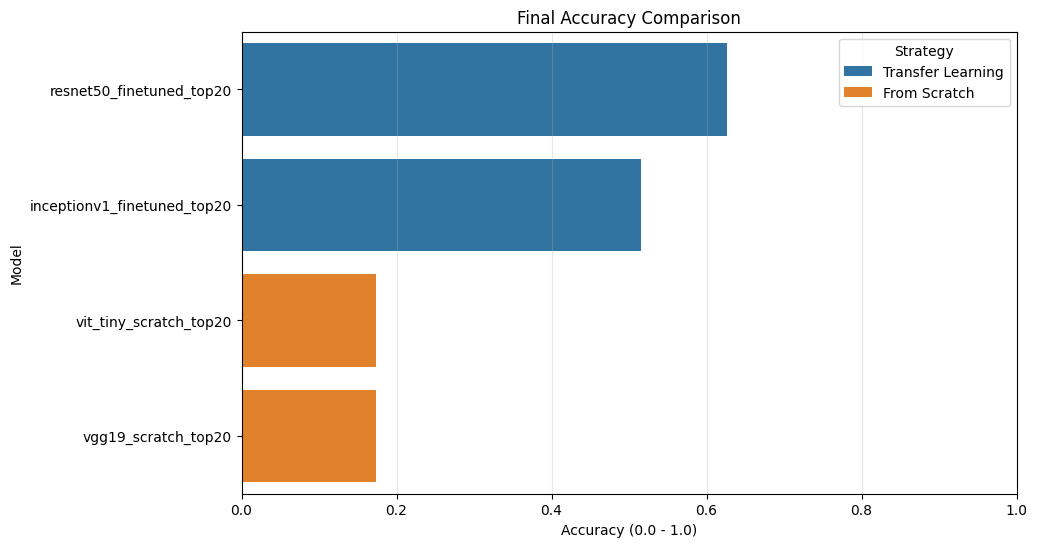

In [2]:
records = []

for name, data in results.items():
    report = data['report']

    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    accuracy = report['accuracy']

    if "scratch" in name:
        strategy = "From Scratch"
    else:
        strategy = "Transfer Learning"

    records.append({
        "Model": name,
        "Strategy": strategy,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

df = pd.DataFrame(records).sort_values(by="Accuracy", ascending=False)

print("FINAL TOURNAMENT LEADERBOARD")
display(df)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Accuracy', y='Model', hue='Strategy', dodge=False)
plt.title("Final Accuracy Comparison")
plt.xlim(0, 1.0)
plt.xlabel("Accuracy (0.0 - 1.0)")
plt.grid(axis='x', alpha=0.3)
plt.show()

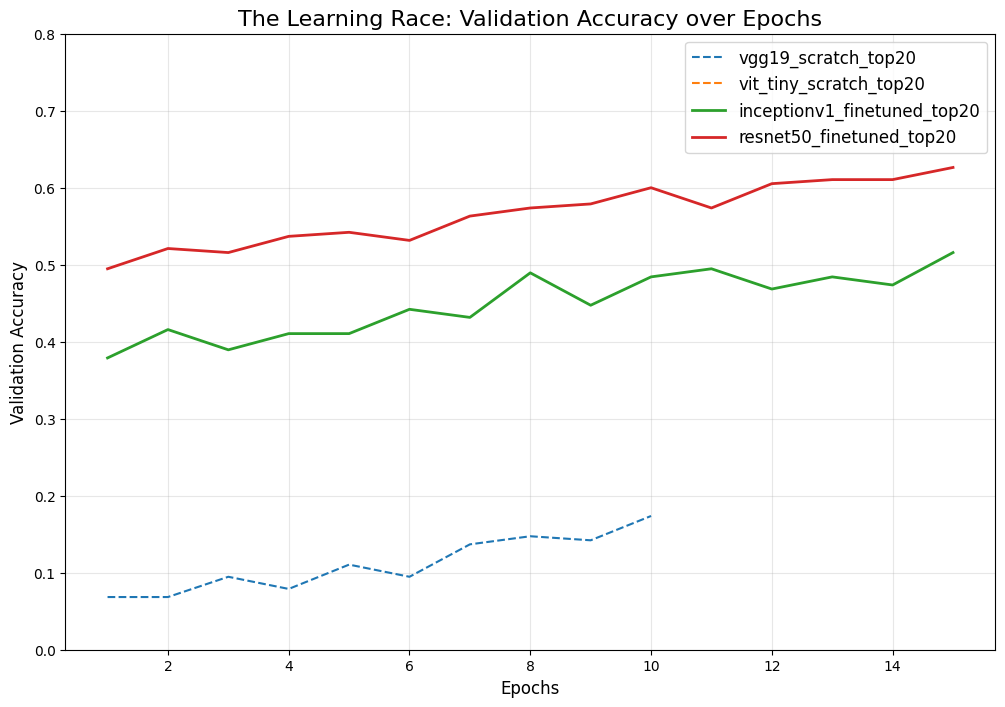

In [3]:
plt.figure(figsize=(12, 8))

for name, data in results.items():
    history = data['history']['val_acc']
    epochs = range(1, len(history) + 1)

    style = '--' if "scratch" in name else '-'
    width = 2 if "finetuned" in name else 1.5

    plt.plot(epochs, history, linestyle=style, linewidth=width, label=f"{name}")

plt.title("The Learning Race: Validation Accuracy over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [4]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

DATA_PATH = os.path.join(PROJECT_PATH, 'stanford_cars_top20')
val_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_dataset = datasets.ImageFolder(DATA_PATH, transform=val_transform)
targets = val_dataset.targets

from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
_, val_idx = next(splitter.split(np.zeros(len(targets)), targets))
val_subset = torch.utils.data.Subset(val_dataset, val_idx)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

def get_probs(model_path, model_arch, num_classes=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(model_path)
    if "resnet" in model_path:
        model = models.resnet50()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif "inception" in model_path:
        model = models.googlenet(aux_logits=False)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif "vgg" in model_path:

        return None, None
    elif "vit" in model_path:

        return None, None

    state_dict = torch.load(f"{PROJECT_PATH}/models/{model_path}.pth")
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    y_score = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            y_score.extend(probs.cpu().numpy())
            y_true.extend(labels.numpy())

    return np.array(y_true), np.array(y_score)